In [1]:
%config IPCompleter.greedy=True
from IPython.display import IFrame

import pandas as pd
import numpy as np
import string
import math

import scipy.stats as sts

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn import preprocessing as prep
import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
from sklearn import discriminant_analysis as disan
from sklearn import calibration as calib
from sklearn import linear_model as lm
from sklearn import svm
from sklearn import gaussian_process as gaup
from sklearn import mixture as mix
from sklearn import tree
from sklearn import ensemble as ens

import tensorflow as tf
from tensorflow import keras
# from keras import models as kermdls
# from keras import layers as kerlrs
# from keras import metrics as kmetrics

from hyperas import optim
from hyperas.distributions import choice, uniform
from hyperopt import Trials, STATUS_OK, tpe

import pickle

Using TensorFlow backend.


In [28]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:XLA_CPU:0', '/device:XLA_GPU:0']


## Helper Functions

#### Helper functions for plotting

In [29]:
def plot_bar_diagram(ax, data, nested=False, plots_labels=None, plots_colors=None, bar_labels='', width=0.4, title='', length_label='',
                     orient='v', legend_loc=None, spines=None):
    """
    Plots single or multiple bar diagrams with data labels on top(aside) of the bars
    :param ax: matplotlib axes
    :param data: pandas DataFrame where rows correspond to bar plots and columns correspond to data labels (columns in data)
    :param nested: boolean. If True, bar plots are plotted on top of each other. If False bar plots are plotted besides each other
    :param bar_labels: pandas DataFrame. labels over the bars. Should be same shape as data
    :param width: float. Bar width
    :param title: string. Plot title
    :param length_label: bar height/width axis label
    :param spines: dictionary of booleans. indicates to plot borders or not. Keys=['left', 'right', 'top', 'bottom'], values=True/False
    :param orient: string. Bar orientation: 'v'-vertical; 'h'-horisontal
    """
    bars = list(data.index)
    cols = list(data.columns)
    cells = data.values.tolist()

    if bar_labels is not None:
        for i, lab in enumerate(bars):
            labels = ([f"{j:.4f}" for j in cells[i]] if bar_labels=='' else bar_labels[i])

    if orient == 'v':
        for i, lab in enumerate(bars):
            label = (bars[i] if plots_labels is None else plots_labels[i])
            color = ('r' if plots_colors is None else plots_colors[i])
            x = np.arange(len(cols))
            bar = ax.bar(x=x + width * (i - len(bars) / 2), height=cells[i], width=width,
                         label=label,
                         color=color,
                         align=('center' if nested else 'edge'))
            if bar_labels is not None:
                autolabel(bar, ax, labels, oriented='v')

        ax.set_xticks(np.arange(len(cols)))
        ax.set_xticklabels(cols)
        if not length_label=='':
            ax.set_ylabel(length_label)
    elif orient == 'h':
        for i, lab in enumerate(bars):
            label = (bars[i] if plots_labels is None else plots_labels[i])
            y = np.arange(len(cols))
            height = width
            bar = ax.barh(y=y + height * (i - len(bars) / 2), width=cells[i], height=width,
                          label=label,
                          color=plots_colors[i],
                          align=('center' if nested else 'edge'))
            if bar_labels is not None:
                autolabel(bar, ax, labels, oriented='h')

        ax.set_yticks(np.arange(len(cols)))
        ax.set_yticklabels(cols)
        if not length_label=='':
            ax.set_xlabel(length_label)
    else:
        raise ValueError('orient parameter value error. expected v or h ')

    if not title == '':
        ttl = ax.title
        ttl.set_position([.5, 1.07])
        ax.set_title(title)
    if legend_loc is not None:
        ax.legend(loc=legend_loc)
    else:
        ax.legend().set_visible(False)

    if spines is None:
        spines = {'left': True,
                  'right': True,
                  'top': True,
                  'bottom': True}
    for i in list(spines.keys()):
        ax.spines[i].set_visible(spines[i])

def autolabel(bars, ax, labels, oriented='v'):
    """Attach a text label displaying its height/width (depends of orientation)."""
    for bar, label in zip(bars, labels):
        if oriented == 'v':
            height = bar.get_height()
            ax.annotate(label,
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 2),
                        textcoords="offset points",
                        ha='center')
        else:
            width = bar.get_width()
            ax.annotate(label,
                        xy=(width, bar.get_y() + bar.get_height() / 2),
                        xytext=(1, 0),
                        textcoords="offset points",
                        ha='left',
                        va='center')

def plot_correlation_matrix(ax, data, cmap='hot', diagonal=False, square=True):
    mask = None
    if diagonal:
        mask = np.zeros_like(data, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
    sns.heatmap(data, ax=ax,
                mask=mask,
                square=square,
                linewidths=1.5,
                cmap=cmap,
                cbar_kws={'shrink': 1, 'ticks': [-1, -.5, 0, 0.5, 1]},
                vmin=-1,
                vmax=1,
                annot=True,
                annot_kws={'size': 8})
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    
def plot_confusion_matrix(model, X, y, ax, normalize=True, title=None):
    """Plots confusion matrix
    Parameters:
    ax =  matplotlib axes
    normalyze = normalization over truth (number_predicted / total_count_of_this_class)
    """
    model.fit(X,y)
    conf_matrix = metrics.confusion_matrix(y_true=y, y_pred=model.predict(X),
                              labels=None)  # returns matrix for sorted classes (i.e 0, 1, 2,..., n)
    classes = y.unique()
    classes.sort()
    n_classes = [len(y[y == c]) for c in classes]
    if normalize == True:
        n_matrix = [[i for j in range(len(n_classes))] for i in n_classes]
        norm_matrix = conf_matrix / np.array(n_classes)
        ns_matrix = np.array([[i for j in enumerate(n_classes)] for i in n_classes])
        labels = np.array([["{0:.2%} \n {1:d} of {2:d}".format(norm_matrix[i, j], conf_matrix[i, j],
                                                               ns_matrix[i, j]) for j, v in
                            enumerate(norm_matrix[i])]
                           for i, v in enumerate(norm_matrix)])

        sns.heatmap(norm_matrix, annot=labels, fmt='', cmap='Blues')
    else:
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

    ax.set_ylabel('True Labels')
    ax.set_xlabel('Predicted Labels')
    if title is None:
        title = model.__class__.__name__
    ax.set_title(title)
    ttl = ax.title
    ttl.set_position([.5, 1.07])

    # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = ax.get_ylim()  # discover the values for bottom and top
    b += 0.5  # Add 0.5 to the bottom
    t -= 0.5  # Subtract 0.5 from the top
    ax.set_ylim(b, t)  # update the ylim(bottom, top) values

#### Helper functions for data preprocessing

In [30]:
#Encode 'Name'
def name_encoder(data):
    data_encoded = []
    for i in data['Name']:
        lname0 = i.split(',')[0].strip() #last name
        ttl = i.split(',')[1].split('.')[0].strip() #title
        lname1 = (i.split('(')[-1].split(')')[0].split()[-1].strip() if '(' in i else '').replace('\"','') #second last name
        data_encoded.append([lname0, lname1, ttl])
    data_encoded = pd.DataFrame(data_encoded, columns=['lname0', 'lname1', 'ttl'], index=data.index)
    return pd.concat([data.reset_index(drop=True), data_encoded], axis=1)

def title_encoder(data):
    mask = {'Don':'Mr',
            'Sir':'Mr',
            'Jonkheer':'Mr',
            'Mme':'Mrs',
            'Lady':'Mrs',
            'the Countess':'Mrs',
            'Dona':'Mrs',
            'Mlle':'Miss',
            'Ms':'Miss',
            'Major':'Mr',
            'Col':'Mr',
            'Capt':'Mr',
            'Rev':'Mr',
            'Dr':'Mr'}
    
    data = name_encoder(data)
    data['ttl'] = data['ttl'].apply(lambda i: mask[i] if i in mask else i)
    if 797 in data['PassengerId'].values:
        data.loc[data_tot['PassengerId']==797, 'ttl'] = 'Mrs'
    mask = {'Mr':1, 'Mrs':2, 'Miss':3, 'Master':4}
    data['ttl'] = data['ttl'].apply(lambda i: mask[i])
    return data

#Encoding 'Embarked'
def embarked_encoder(data):
    if len(data.loc[data['Embarked'].isnull()].index)>0:
        data = data.fillna(value={'Embarked':'C'})
    mask = {'C':0, 'S':1, 'Q':2}
    data['Embarked'] = data['Embarked'].apply(lambda i: mask[i])
    return data

# Clean text function
def clean_text(text):
    text = ''.join([c for c in text if c not in string.punctuation]).strip()
    text = ''.join(text.split())
    return text

# This function is used to return sub-groups by unique and non-unique tickets from a group by SibSP and Parch
def grps_by_size(grp):
    #group size > 1
    grp1 = None
    #group size == 1
    grp0 = None
    for g in grp.groups:
        grp_ = grp.get_group(g)
        if len(grp.get_group(g).index)>1:
            if grp1 is None:
                grp1 = grp_
            else:
                grp1 = pd.concat([grp1, grp_])
        else:
            if grp0 is None:
                grp0 = grp_
            else:
                grp0 = pd.concat([grp0, grp_])
    return (grp0, grp1)

def get_family_groups(data):
    families0 = data.loc[(data['SibSp']>0) & (data['Parch']==0)]
    families1 = data.loc[data['Parch']>0]
    singles = data.loc[(data['SibSp']==0) & (data['Parch']==0)]
    
    data['Ticket'] = data['Ticket'].apply(lambda i: clean_text(i))
    
    #singles
    sig_grp = singles.groupby('Ticket')
    #families NO children
    fam0_grp = families0.groupby('Ticket')
    #families w/children
    fam1_grp = families1.groupby('Ticket')

    #no family, unique ticket
    sig0 = grps_by_size(sig_grp)[0]
    #no family, matching tickets
    sig1 = grps_by_size(sig_grp)[1]
    #has family, no children, unique ticket
    fam0 = grps_by_size(fam0_grp)[0]
    #has family, no children, matching ticket
    fam1 = grps_by_size(fam0_grp)[1]
    #has family, has children, unique ticket
    famch0 = grps_by_size(fam1_grp)[0]
    #has family, has children, matching ticket
    famch1 = grps_by_size(fam1_grp)[1]
    return [sig0, sig1, fam0, fam1, famch0, famch1]

def get_fgrp_mask(data):
    # Family groups
    fam_grps = get_family_groups(data)
    
    # Make a mask of family groups labels
    fgrp_mask = {}
    for idx, grp in enumerate(fam_grps):
        for pid in grp['PassengerId']:
            fgrp_mask[pid] = idx
    return fgrp_mask

def get_fare_mask(data):
    data['Ticket'] = data['Ticket'].apply(lambda i: clean_text(i))
    # Make a mask of ticket fare
    data = data.fillna(value={'Fare':0})
    fare_mask = {}
    for tic in data['Ticket'].unique():
        # subgroup with matching tickets
        tic_grp = data.loc[data['Ticket']==tic]

        # passenger class that the subgroup belongs to
        c = tic_grp['Pclass'].values[0]

        # ticket fare of the subgroup
        # all subgroup members have the same ticket fare initially
        fare_grp = tic_grp['Fare'].values[0]

        # if a subgroup fare is 0 then assign a mean of the fare of the Pclass that the subgroup belongs to
        if fare_grp == 0:
            fare_i = np.mean(data.loc[data['Pclass']==c, 'Fare'])
            for pid in tic_grp['PassengerId']:
                fare_mask[pid] = fare_i

        # recalculate fare for subrgoup members: fare_i = group_fare / n_members
        if len(tic_grp.index) > 1:
            if fare_grp > 0:
                if np.mean(tic_grp['Fare'])==fare_grp: #check if all group members have same fare
                    fare_i = fare_grp / len(tic_grp.index)
                    for pid in tic_grp['PassengerId']:
                        fare_mask[pid] = fare_i
                else:
                    for pid in tic_grp['PassengerId']:
                        fare_mask[pid] = tic_grp.loc[tic_grp['PassengerId']==pid, 'Fare'].values[0]
        # keep fare value for passengers with unuque tickets
        else:
            if fare_grp > 0:
                fare_i = fare_grp
                for pid in tic_grp['PassengerId']:
                    fare_mask[pid] = fare_i
    return fare_mask

def get_ticket_mask(data):
    data['Ticket'] = data['Ticket'].apply(lambda i: clean_text(i))
    # Make a mask of ticket codes
    # For ticket IDs that belongs to multiple passengers, set 1 othervise set 0
    m_tickets = []
    for tic in data['Ticket'].unique():
        if len(data.loc[data['Ticket']==tic].index) > 1:
            m_tickets.append(tic)

    ticket_mask = {}        
    for pid in data['PassengerId']:
        tic = data.loc[data['PassengerId']==pid, 'Ticket'].values[0]
        if tic in m_tickets:
            ticket_mask[pid] = 1
        else:
            ticket_mask[pid] = 0
    return ticket_mask

# Encode family groups
# This function adds new class variable 'fgrp' that indicates a group that a passenger belongs to.
def family_groups_encoder(data, fgrp_mask):
    # assign a label
    data['fgrp'] = data['PassengerId'].apply(lambda i: fgrp_mask[i])
    # replace labels with corresponding counts
    data['fgrp'] = data['fgrp'].apply(lambda i: len(data.loc[data['fgrp']==i].index))
    return data

# Recalculate ticket fare in the family groups and fill missing values with a mean for corresponding passenger class and then log-transform.
def fare_encoder(data, fare_mask):
    data['Fare'] = data['PassengerId'].apply(lambda i: fare_mask[i])
    data['Fare'] = data['Fare'].apply(np.log)
    return data

# Encode tickets
def ticket_encoder(data, ticket_mask):
    data['Ticket'] = data['PassengerId'].apply(lambda i: ticket_mask[i])
    return data

# Encode 'Sex'
def sex_encoder(data):
    mask = {'male':0, 'female':1}
    data['Sex'] = data['Sex'].apply(lambda i: mask[i])
    return data

# Add family size
def fam_size(data):
    data['famsize'] = data['SibSp'] + data['Parch']
    return data

#Encoding 'Pclass' (to labels 0,1,2)
def pclass_encoder(data):
    data['Pclass'] = data['Pclass'].apply(lambda i: i-1)
    return data

def age_transformer(data, cluster_model):
    data['Age'] = data['Age'].apply(np.log)
    X = data['Age'].to_frame()
    data['Age_cls'] = cluster_model.predict(X)
    data['Age_cls'] = data['Age_cls'].astype(int)
    return data

#### Helper functions for model training

In [31]:
# Tune parameters
def param_tune(model, X_train, y_train, param_ranges, scoring, cv, refit=''):
    if refit == '': refit = list(scoring.keys())[0]
    gsearch = model_selection.GridSearchCV(estimator=model, param_grid=param_ranges, scoring=scoring, cv=cv, refit=refit, return_train_score=True,
                           n_jobs=-1)
    gsearch.fit(X_train, y_train)
    cv_res = pd.DataFrame(gsearch.cv_results_)
    cv_res_sel = []
    for i in list(scoring.keys()):
        df = cv_res.loc[cv_res['rank_test_%s' % i] == 1].head(1)
        cv_res_sel.append(df[['mean_train_%s' % i, 'std_train_%s' % i, 'mean_test_%s' % i, 'std_test_%s' % i]].values[0])

    cv_res_sel = pd.DataFrame(cv_res_sel, index=list(scoring.keys()), columns=['mean_train', 'std_train', 'mean_test', 'std_test'])
    cv_results = cv_res_sel.T
    cv_results = cv_results.apply(lambda i: np.absolute(i))
    return gsearch.best_estimator_, gsearch.best_params_, gsearch.best_score_, cv_results

# Cross-validation report
def cv_rep(model, X, y, cv, scoring):
    cv_res = model_selection.cross_validate(model, X, y, scoring=scoring, cv=cv, return_train_score=True, n_jobs=-1)
    cv_res = [[np.mean(cv_res['train_%s' % i]), np.std(cv_res['train_%s' % i]), np.mean(cv_res['test_%s' % i]), np.std(cv_res['test_%s' % i])] for i in list(scoring.keys())]
    cv_results = pd.DataFrame(cv_res, index=list(scoring.keys()), columns=['mean_train', 'std_train', 'mean_test', 'std_test'])
    cv_results = cv_results.T
    cv_results = cv_results.apply(lambda i: np.absolute(i))
    return cv_results

# Tune model parameters and print CV report
def train_best_model(model, param_ranges, X_train, y_train, scoring, cv, refit):
    model, best_params, best_score, cv_res = param_tune(model, X_train, y_train, param_ranges, scoring, cv, refit=refit)
    print(cv_res)
    print(best_params)
    return model, cv_res

# Tune model parameters and print CV report for calibrated classifier model
def train_best_model_cal(model, param_ranges, X_train, y_train, scoring, cv, refit):
    if model.__class__.__name__=='CalibratedClassifierCV':
         model_cal= model 
    else:
        model_cal = calib.CalibratedClassifierCV(base_estimator=model, method='sigmoid', cv=cv)
    model_cal, best_params, best_score, cv_res = param_tune(model_cal, X_train, y_train, param_ranges, scoring, cv, refit=refit)
    print(cv_res)
    print(best_params)
    return model, cv_res

def roc_auc_score_ovr(y_true, y_score):
    return metrics.roc_auc_score(y_true, y_score, average='macro', sample_weight=None, max_fpr=None,
                                 multi_class='ovr', labels=None)

def roc_auc_score_ovo(y_true, y_score):
    return metrics.roc_auc_score(y_true, y_score, average='macro', sample_weight=None, max_fpr=None,
                                 multi_class='ovo', labels=None)

### Import data

In [32]:
#import train dataset
data_train = pd.read_csv('train.csv')

#import test dataset
data_test = pd.read_csv('test.csv')

In [33]:
# Concatinate train & test data
data_tot = pd.concat([data_train, data_test], ignore_index=True)

In [34]:
# get fgrp mask
fgrp_mask = get_fgrp_mask(data_tot)
# get fare mask
fare_mask = get_fare_mask(data_tot)
# get ticket mask
ticket_mask = get_ticket_mask(data_tot)

### Age prediction

In [35]:
#Define clustering model
age_clast_model = mix.BayesianGaussianMixture(n_components=3, 
                                              covariance_type='spherical', 
                                              init_params='kmeans', 
                                              weight_concentration_prior_type='dirichlet_distribution', 
                                              max_iter=1000,
                                              random_state=30)

#Fit model
X = data_tot['Age'].dropna().copy().apply(np.log).to_frame()
age_clast_model = age_clast_model.fit(X)

### Preprocess data

Use transformer functions defined above.
Also drop Sex as it is highly correlated with ttl. Basicaly the ttl already contains gender information.

In [47]:
data = family_groups_encoder(data_tot.copy(), fgrp_mask)
data = fare_encoder(data, fare_mask)
data = ticket_encoder(data, ticket_mask)
data = title_encoder(data)
data = sex_encoder(data)
data = fam_size(data)
data = embarked_encoder(data)
data = pclass_encoder(data)

data = data[data['Age'].notna()].copy()
data = age_transformer(data, age_clast_model)

data = data[['Age', 'Age_cls', 'Fare', 'ttl', 'fgrp', 'famsize', 'Ticket', 'Pclass', 'Embarked']]
data = pd.get_dummies(data, columns=['ttl', 'Pclass', 'Embarked'])

# scaler = prep.StandardScaler(copy=False, with_mean=False, with_std=True)
# data['fgrp'] = scaler.fit_transform(np.array(data['fgrp']).reshape(-1,1))

data['Age'] = data['Age'].apply(np.exp)
data['Fare'] = data['Fare'].apply(np.exp)

data.to_csv('age_data.csv', index=False)

In [48]:
data.head(5)

,Age,Age_cls,Fare,fgrp,famsize,Ticket,ttl_1,ttl_2,ttl_3,ttl_4,Pclass_0,Pclass_1,Pclass_2,Embarked_0,Embarked_1,Embarked_2
0,22.0,2,7.25000,38,1,0,1,0,0,0,0,0,1,0,1,0
1,38.0,0,35.64165,174,1,1,0,1,0,0,1,0,0,1,0,0
2,26.0,2,7.92500,682,0,0,0,0,1,0,0,0,1,0,1,0
3,35.0,0,26.55000,174,1,1,0,1,0,0,1,0,0,0,1,0
4,35.0,0,8.05000,682,0,0,1,0,0,0,0,0,1,0,1,0


In [49]:
data.columns.to_list()

['Age',
 'Age_cls',
 'Fare',
 'fgrp',
 'famsize',
 'Ticket',
 'ttl_1',
 'ttl_2',
 'ttl_3',
 'ttl_4',
 'Pclass_0',
 'Pclass_1',
 'Pclass_2',
 'Embarked_0',
 'Embarked_1',
 'Embarked_2']

### Train classification model for age class prediction

In [2]:
def data():
    df = pd.read_csv('age_data.csv')
    selected_features = df.columns.to_list()
    selected_features = selected_features[2:]
    target = 'Age_cls'
    
    train, test = model_selection.train_test_split(df, test_size=0.2)
    train, val = model_selection.train_test_split(train, test_size=0.2)
    X_train = train[selected_features]
    X_val = val[selected_features]
    Y_train = train[target]
    Y_val = val[target]
    
    scaler = prep.StandardScaler(copy=False, with_mean=True, with_std=True)
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.fit_transform(X_val)
    
    Y_train = keras.utils.to_categorical(Y_train, 3)
    Y_val = keras.utils.to_categorical(Y_val, 3)
    return X_train, Y_train, X_val, Y_val

In [3]:
def create_model(X_train, Y_train, X_val, Y_val):
    
    class_weights = {}
    for i in range(Y_train.shape[1]):
        class_weights[i] = Y_train.shape[0] / Y_train[Y_train[:,i]==1].shape[0] / 2
    
    # select features
    selected_features=['Fare',
                   'fgrp',
                   'famsize',
                   'Ticket',
                   'ttl_1',
                   'ttl_2',
                   'ttl_3',
                   'ttl_4', 
                   'Pclass_0',
                   'Pclass_1',
                   'Pclass_2',
                   'Embarked_0',
                   'Embarked_1',
                   'Embarked_2']
    
    # model
    model = keras.Sequential()
    
    # input
    model.add(keras.layers.Dense({{choice([32,64,128])}}, 
                                 input_dim=len(selected_features),
                                 kernel_initializer=keras.initializers.he_normal(seed=30),
                                 bias_initializer=keras.initializers.Constant({{uniform(0.01,0.5)}})))
    model.add(keras.layers.Activation(keras.layers.LeakyReLU(alpha={{uniform(0.05,0.2)}})))
    
    # hidden layers
    nh_relu = {{choice([2,4,6])}}
    nh_tanh = {{choice([2,4,6])}}
    nh_sig = {{choice([2,4,6])}}
    
    is_relu = {{choice([True,False])}}
    is_tanh = {{choice([True,False])}}
    is_sig = {{choice([True,False])}}
    
    if is_relu==True:
        for i in range(nh_relu):
            model.add(keras.layers.Dense({{choice([32,64])}},
                                     kernel_initializer=keras.initializers.he_normal(seed=30),
                                     bias_initializer=keras.initializers.Constant({{uniform(0.01,0.5)}})))
            model.add(keras.layers.Activation(keras.layers.LeakyReLU(alpha={{uniform(0.05,0.2)}})))
            model.add(keras.layers.Dropout(rate={{uniform(0.05,0.2)}}, seed=30))
    
    if is_tanh==True:
        for i in range(nh_tanh):
            model.add(keras.layers.Dense({{choice([32,64])}},
                                     kernel_initializer=keras.initializers.glorot_normal(seed=30),
                                     bias_initializer=keras.initializers.Constant({{uniform(0.01,0.5)}})))
            model.add(keras.layers.Activation('tanh'))
            model.add(keras.layers.Dropout(rate={{uniform(0.05,0.2)}}, seed=30))
        
    if is_sig==True:    
        for i in range(nh_sig):
            model.add(keras.layers.Dense({{choice([32,64])}},
                                     kernel_initializer=keras.initializers.glorot_normal(seed=30),
                                     bias_initializer=keras.initializers.Constant({{uniform(0.01,0.5)}})))
            model.add(keras.layers.Activation('sigmoid'))
            model.add(keras.layers.Dropout(rate={{uniform(0.05,0.2)}}, seed=30))
    
    # output    
    model.add(keras.layers.Dense(3,
                                 kernel_initializer=keras.initializers.glorot_normal(seed=30),
                                 bias_initializer=keras.initializers.Constant({{uniform(0.01,0.5)}})))
    model.add(keras.layers.Activation('sigmoid'))
    
    # optimizers
    optim = keras.optimizers.Adam(lr={{uniform(0.00001,0.001)}},
                                 beta_1={{uniform(0.8,0.999)}},
                                 beta_2={{uniform(0.8,0.999)}},
                                 amsgrad={{choice([True,False])}})
        
    METRICS = [keras.metrics.CategoricalAccuracy(name='CategoricalAccuracy'),
               keras.metrics.CategoricalCrossentropy(name='CategoricalCrossentropy'),
               keras.metrics.AUC(name='AUC')]
        
    model.compile(loss='categorical_crossentropy', metrics=METRICS, optimizer=optim)
    hist = model.fit(X_train, Y_train,
              class_weight=class_weights,
              batch_size=32,
              epoch=200,
              verbose=3,
              validation_data=(X_val, Y_val))
    
    validation_acc = np.amax(hist.history['val_CategoricalAccuracy']) 
    return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}

In [3]:
def create_model(X_train, Y_train, X_val, Y_val):
    
    class_weights = {}
    for i in range(Y_train.shape[1]):
        class_weights[i] = Y_train.shape[0] / Y_train[Y_train[:,i]==1].shape[0] / 2
    
    # select features
    selected_features=['Fare',
                   'fgrp',
                   'famsize',
                   'Ticket',
                   'ttl_1',
                   'ttl_2',
                   'ttl_3',
                   'ttl_4', 
                   'Pclass_0',
                   'Pclass_1',
                   'Pclass_2',
                   'Embarked_0',
                   'Embarked_1',
                   'Embarked_2']
    
    # model
    model = keras.Sequential()
    
    # input
    model.add(keras.layers.Dense({{choice([32,64])}}, 
                             input_dim=len(selected_features),
                             kernel_initializer=keras.initializers.he_normal(seed=30),
                             bias_initializer=keras.initializers.Constant({{uniform(0.01,0.5)}})))
    model.add(keras.layers.Activation(keras.layers.LeakyReLU(alpha={{uniform(0.05,0.2)}})))
    model.add(keras.layers.Dropout(rate={{uniform(0.05,0.2)}}, seed=30))
    
    # hidden layers
    nh_relu = {{choice([2,4,6])}}
    nh_tanh = {{choice([2,4,6])}}
    nh_sig = {{choice([2,4,6])}}
    
    for i in range(nh_relu):
        model.add(keras.layers.Dense({{choice([32,64])}},
                                 kernel_initializer=keras.initializers.he_normal(seed=30),
                                 bias_initializer=keras.initializers.Constant({{uniform(0.01,0.5)}})))
        model.add(keras.layers.Activation(keras.layers.LeakyReLU(alpha={{uniform(0.05,0.2)}})))
        model.add(keras.layers.Dropout(rate={{uniform(0.05,0.2)}}, seed=30))

    for i in range(nh_tanh):
        model.add(keras.layers.Dense({{choice([32,64])}},
                                 kernel_initializer=keras.initializers.glorot_normal(seed=30),
                                 bias_initializer=keras.initializers.Constant({{uniform(0.01,0.5)}})))
        model.add(keras.layers.Activation('tanh'))
        model.add(keras.layers.Dropout(rate={{uniform(0.05,0.2)}}, seed=30))
        
    for i in range(nh_sig):
        model.add(keras.layers.Dense({{choice([32,64])}},
                                 kernel_initializer=keras.initializers.glorot_normal(seed=30),
                                 bias_initializer=keras.initializers.Constant({{uniform(0.01,0.5)}})))
        model.add(keras.layers.Activation('sigmoid'))
        model.add(keras.layers.Dropout(rate={{uniform(0.05,0.2)}}, seed=30))
    
    # output  
    model.add(keras.layers.Dense(3,
                             kernel_initializer=keras.initializers.glorot_normal(seed=30),
                             bias_initializer=keras.initializers.Constant({{uniform(0.01,0.5)}})))
    model.add(keras.layers.Activation('sigmoid'))
    
    # optimizers
    optim = keras.optimizers.Adam(lr={{uniform(0.00001,0.0001)}},
                                 beta_1={{uniform(0.8,0.999)}},
                                 beta_2={{uniform(0.8,0.999)}},
                                 amsgrad={{choice([True,False])}})

    METRICS = [keras.metrics.CategoricalAccuracy(name='CategoricalAccuracy'),
               keras.metrics.CategoricalCrossentropy(name='CategoricalCrossentropy'),
               keras.metrics.AUC(name='AUC')]

    model.compile(loss='categorical_crossentropy', metrics=METRICS, optimizer=optim)
    hist = model.fit(X_train, Y_train,
              class_weight=class_weights,
              batch_size=32,
              epoch=200,
              verbose=0,
              validation_data=(X_val, Y_val))

    validation_acc = np.amax(hist.history['val_AUC']) 
    print('Best validation acc of epoch:', validation_acc)
    return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}

In [4]:
# if __name__ == '__main__':
best_run, best_model = optim.minimize(model=create_model,
                                      data=data,
                                      algo=tpe.suggest,
                                      max_evals=500,
                                      trials=Trials(),
                                      notebook_name='Titanic_KERAS_01',
                                      verbose=1)
X_train, Y_train, X_val, Y_val = data()
print("Evalutation of best performing model:")
print(best_model.evaluate(X_val, Y_val))
print("Best performing model chosen hyper-parameters:")
print(best_run)

>>> Imports:
#coding=utf-8

try:
    from IPython.display import IFrame
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import string
except:
    pass

try:
    import math
except:
    pass

try:
    import scipy.stats as sts
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import matplotlib.gridspec as gridspec
except:
    pass

try:
    import seaborn as sns
except:
    pass

try:
    from sklearn import preprocessing as prep
except:
    pass

try:
    import sklearn.metrics as metrics
except:
    pass

try:
    import sklearn.model_selection as model_selection
except:
    pass

try:
    from sklearn import discriminant_analysis as disan
except:
    pass

try:
    from sklearn import calibration as calib
except:
    pass

try:
    from sklearn import linear_model as lm
except:
    pass

try:
    from sklearn import svm
except:
    pass

try:
    from sklearn import gaussian_pr

In [2]:
data = pd.read_csv('age_data.csv')
selected_features = data.columns.to_list()
selected_features = selected_features[2:]
selected_features=['Fare',
                   'fgrp',
                   'famsize',
                   'Ticket',
                   'ttl_1',
                   'ttl_2',
                   'ttl_3',
                   'ttl_4', 
                   'Pclass_0',
                   'Pclass_1',
                   'Pclass_2',
                   'Embarked_0',
                   'Embarked_1',
                   'Embarked_2']
target = 'Age_cls'

train, test = model_selection.train_test_split(data, test_size=0.2)
train, val = model_selection.train_test_split(train, test_size=0.2)
X_train = train[selected_features]
X_val = val[selected_features]
X_test = test[selected_features]
Y_train = train[target]
Y_val = val[target]
Y_test = test[target]


scaler = prep.StandardScaler(copy=False, with_mean=True, with_std=True)
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)

# scaler = prep.StandardScaler(copy=False, with_mean=False, with_std=False)
# X_train['Fare'] = scaler.fit_transform(np.array(X_train['Fare']).reshape(-1,1))
# X_val['Fare'] = scaler.fit_transform(np.array(X_val['Fare']).reshape(-1,1))
# X_test['Fare'] = scaler.fit_transform(np.array(X_test['Fare']).reshape(-1,1))
    
Y_train = keras.utils.to_categorical(Y_train, 3)
Y_val = keras.utils.to_categorical(Y_val, 3)
Y_test = keras.utils.to_categorical(Y_test, 3)

In [12]:
best_run_params = pd.Series(best_run)
best_run_params.to_csv("best_run_params.csv")

In [3]:
data = pd.read_csv('best_run_params.csv')
# best_run_params.columns.to_list()
best_run_params = {}
for idx, row in data.iterrows():
#     print(type(row['Unnamed: 0']))
    best_run_params[row['Unnamed: 0']] = row['0']

In [6]:
results = best_model.evaluate(X_test, Y_test, verbose=1)

7/7 [==============================] - 0s 997us/step - loss: 0.8046 - CategoricalAccuracy: 0.6476 - CategoricalCrossentropy: 0.8070 - AUC: 0.8505


(3.5, -0.5)

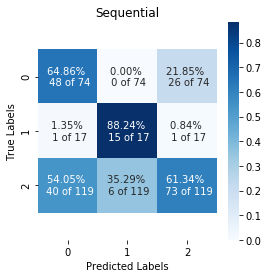

In [8]:
fig = plt.figure()
fig.set_size_inches(4,4)
ax=fig.add_subplot(1,1,1)
title=None
# plot_confusion_matrix(model_st, X, y, ax=fig.add_subplot(1,1,1), normalize=True, title='')

conf_matrix = metrics.confusion_matrix(y_true=[np.argmax(i) for i in Y_test], 
                                       y_pred=[np.argmax(i) for i in best_model.predict(X_test)],
                                       labels=None)  # returns matrix for sorted classes (i.e 0, 1, 2,..., n)

classes = [0,1,2]
n_classes = [Y_test[Y_test[:,c]==1].shape[0] for c in classes]

normalize = True

if normalize == True:
    n_matrix = [[i for j in range(len(n_classes))] for i in n_classes]
    norm_matrix = conf_matrix / np.array(n_classes)
    ns_matrix = np.array([[i for j in enumerate(n_classes)] for i in n_classes])
    labels = np.array([["{0:.2%} \n {1:d} of {2:d}".format(norm_matrix[i, j], conf_matrix[i, j],
                                                           ns_matrix[i, j]) for j, v in
                        enumerate(norm_matrix[i])]
                       for i, v in enumerate(norm_matrix)])

    sns.heatmap(norm_matrix, annot=labels, fmt='', cmap='Blues')
else:
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

ax.set_ylabel('True Labels')
ax.set_xlabel('Predicted Labels')
if title is None:
    title = best_model.__class__.__name__
ax.set_title(title)
ttl = ax.title
ttl.set_position([.5, 1.07])

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = ax.get_ylim()  # discover the values for bottom and top
b += 0.5  # Add 0.5 to the bottom
t -= 0.5  # Subtract 0.5 from the top
ax.set_ylim(b, t)  # update the ylim(bottom, top) values

In [27]:
class_weights = {}
for i in range(Y_train.shape[1]):
        class_weights[i] = Y_train.shape[0] / Y_train[Y_train[:,i]==1].shape[0] / 2

In [56]:
def re_create_model(X_train, Y_train, X_val, Y_val, X_test, Y_test, best_run_params):
    
    dense_in = [32,64,128]
    dense_h = [32,64]
    nh_relu = [2,4,6]
    nh_tanh = [2,4,6]
    nh_sig = [2,4,6]
    
    
    class_weights = {}
    for i in range(Y_train.shape[1]):
        class_weights[i] = Y_train.shape[0] / Y_train[Y_train[:,i]==1].shape[0] / 2
    
    # select features
    selected_features=['Fare',
                   'fgrp',
                   'famsize',
                   'Ticket',
                   'ttl_1',
                   'ttl_2',
                   'ttl_3',
                   'ttl_4', 
                   'Pclass_0',
                   'Pclass_1',
                   'Pclass_2',
                   'Embarked_0',
                   'Embarked_1',
                   'Embarked_2']
    
    # model
    model = keras.Sequential()
    
    # input
    model.add(keras.layers.Dense(dense_in[int(best_run_params['Dense'])], 
                                 input_dim=len(selected_features),
                                 kernel_initializer=keras.initializers.he_normal(seed=30),
                                 bias_initializer=keras.initializers.Constant(best_run_params['Constant'])))
    model.add(keras.layers.Activation(keras.layers.LeakyReLU(alpha=best_run_params['alpha'])))
    
    # hidden layers
    nh_relu = nh_relu[int(best_run_params['nh_relu'])]
    nh_tanh = nh_tanh[int(best_run_params['nh_relu_1'])]
    nh_sig = nh_sig[int(best_run_params['nh_relu_2'])]
    
    is_relu = bool(best_run_params['is_relu'])
    is_tanh = bool(best_run_params['is_relu_1'])
    is_sig = bool(best_run_params['is_relu_2'])
    
    if is_relu==True:
        for i in range(nh_relu):
            model.add(keras.layers.Dense(dense_h[int(best_run_params['Dense_1'])],
                                     kernel_initializer=keras.initializers.he_normal(seed=30),
                                     bias_initializer=keras.initializers.Constant(best_run_params['Constant_1'])))
            model.add(keras.layers.Activation(keras.layers.LeakyReLU(alpha=best_run_params['alpha_1'])))
            model.add(keras.layers.Dropout(rate=best_run_params['alpha_2'], seed=30))
    
    if is_tanh==True:
        for i in range(nh_tanh):
            model.add(keras.layers.Dense(dense_h[int(best_run_params['Dense_2'])],
                                     kernel_initializer=keras.initializers.glorot_normal(seed=30),
                                     bias_initializer=keras.initializers.Constant(best_run_params['Constant_2'])))
            model.add(keras.layers.Activation('tanh'))
            model.add(keras.layers.Dropout(rate=best_run_params['alpha_3'], seed=30))
        
    if is_sig==True:    
        for i in range(nh_sig):
            model.add(keras.layers.Dense(dense_h[int(best_run_params['Dense_3'])],
                                     kernel_initializer=keras.initializers.glorot_normal(seed=30),
                                     bias_initializer=keras.initializers.Constant(best_run_params['Constant_3'])))
            model.add(keras.layers.Activation('sigmoid'))
            model.add(keras.layers.Dropout(rate=best_run_params['alpha_4'], seed=30))
    
    # output    
    model.add(keras.layers.Dense(3,
                                 kernel_initializer=keras.initializers.glorot_normal(seed=30),
                                 bias_initializer=keras.initializers.Constant(best_run_params['Constant_4'])))
    model.add(keras.layers.Activation('sigmoid'))
    
    # optimizers
#     lr=0.0008759305600879901
    optim = keras.optimizers.Adam(lr=0.0001,
                                 beta_1=best_run_params['beta_1'],
                                 beta_2=best_run_params['beta_1_1'],
                                 amsgrad=bool(best_run_params['is_relu_3']))
        
    METRICS = [keras.metrics.CategoricalAccuracy(name='CategoricalAccuracy'),
               keras.metrics.CategoricalCrossentropy(name='CategoricalCrossentropy'),
               keras.metrics.AUC(name='AUC')]
        
    model.compile(loss='categorical_crossentropy', metrics=METRICS, optimizer=optim)
#     model.summary()
    hist = model.fit(X_train, Y_train,
              class_weight=class_weights,
              batch_size=32,
              epoch=300,
              verbose=0,
              validation_data=(X_val, Y_val))
    
    results = model.evaluate(X_test, Y_test, verbose=1)
#     print(hist.history['AUC'])
    fig = plt.figure()
    fig.set_size_inches(16,16)

    ax=fig.add_subplot(3,2,1)
    ax.plot(hist.history['AUC'])
    ax.plot(hist.history['CategoricalCrossentropy'])
    ax.legend(['Metric', 'Loss'])
    ax.set_title('Train')

    ax=fig.add_subplot(3,2,2)
    ax.plot(hist.history['val_AUC'])
    ax.plot(hist.history['val_CategoricalCrossentropy'])
    ax.legend(['Metric', 'Loss'])
    ax.set_title('Test')

    ax=fig.add_subplot(3,2,3)
    ax.plot(hist.history['CategoricalCrossentropy'])
    ax.plot(hist.history['val_CategoricalCrossentropy'])
    ax.legend(['Train', 'Test'])
    ax.set_title('Loss')

    ax=fig.add_subplot(3,2,4)
    ax.plot(hist.history['AUC'])
    ax.plot(hist.history['val_AUC'])
    ax.legend(['Train', 'Test'])
    ax.set_title('Metric')
    
#     fig = plt.figure()
#     fig.set_size_inches(4,4)
    ax=fig.add_subplot(3,2,5)
    title=None
    # plot_confusion_matrix(model_st, X, y, ax=fig.add_subplot(1,1,1), normalize=True, title='')

    conf_matrix = metrics.confusion_matrix(y_true=[np.argmax(i) for i in Y_test], 
                                           y_pred=[np.argmax(i) for i in model.predict(X_test)],
                                           labels=None)  # returns matrix for sorted classes (i.e 0, 1, 2,..., n)

    classes = [0,1,2]
    n_classes = [Y_test[Y_test[:,c]==1].shape[0] for c in classes]

    normalize = True

    if normalize == True:
        n_matrix = [[i for j in range(len(n_classes))] for i in n_classes]
        norm_matrix = conf_matrix / np.array(n_classes)
        ns_matrix = np.array([[i for j in enumerate(n_classes)] for i in n_classes])
        labels = np.array([["{0:.2%} \n {1:d} of {2:d}".format(norm_matrix[i, j], conf_matrix[i, j],
                                                               ns_matrix[i, j]) for j, v in
                            enumerate(norm_matrix[i])]
                           for i, v in enumerate(norm_matrix)])

        sns.heatmap(norm_matrix, annot=labels, fmt='', cmap='Blues')
    else:
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

    ax.set_ylabel('True Labels')
    ax.set_xlabel('Predicted Labels')
    if title is None:
        title = model.__class__.__name__
    ax.set_title(title)
    ttl = ax.title
    ttl.set_position([.5, 1.07])

    # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = ax.get_ylim()  # discover the values for bottom and top
    b += 0.5  # Add 0.5 to the bottom
    t -= 0.5  # Subtract 0.5 from the top
    ax.set_ylim(b, t)  # update the ylim(bottom, top) values
    
    plt.show()

In [61]:
# def re_create_model(X_train, Y_train, X_val, Y_val, X_test, Y_test, best_run_params):

dense_in = [32,64,128]
dense_h = [32,64]
nh_relu = [2,4,6]
nh_tanh = [2,4,6]
nh_sig = [2,4,6]


class_weights = {}
for i in range(Y_train.shape[1]):
    class_weights[i] = Y_train.shape[0] / Y_train[Y_train[:,i]==1].shape[0] / 2

# select features
selected_features=['Fare',
               'fgrp',
               'famsize',
               'Ticket',
               'ttl_1',
               'ttl_2',
               'ttl_3',
               'ttl_4', 
               'Pclass_0',
               'Pclass_1',
               'Pclass_2',
               'Embarked_0',
               'Embarked_1',
               'Embarked_2']

# model
model = keras.Sequential()

# input
model.add(keras.layers.Dense(dense_in[int(best_run_params['Dense'])], 
                             input_dim=len(selected_features),
                             kernel_initializer=keras.initializers.he_normal(seed=30),
                             bias_initializer=keras.initializers.Constant(best_run_params['Constant'])))
model.add(keras.layers.Activation(keras.layers.LeakyReLU(alpha=best_run_params['alpha'])))

# hidden layers
nh_relu = nh_relu[int(best_run_params['nh_relu'])]
nh_tanh = nh_tanh[int(best_run_params['nh_relu_1'])]
nh_sig = nh_sig[int(best_run_params['nh_relu_2'])]

is_relu = bool(best_run_params['is_relu'])
is_tanh = bool(best_run_params['is_relu_1'])
is_sig = bool(best_run_params['is_relu_2'])

# print(nh_relu)
# print(nh_tanh)
# print(nh_sig)
# print(is_relu)
# print(is_tanh)
# print(is_sig)

if is_relu==True:
    for i in range(nh_relu):
        model.add(keras.layers.Dense(dense_h[int(best_run_params['Dense_1'])],
                                 kernel_initializer=keras.initializers.he_normal(seed=30),
                                 bias_initializer=keras.initializers.Constant(best_run_params['Constant_1'])))
        model.add(keras.layers.Activation(keras.layers.LeakyReLU(alpha=best_run_params['alpha_1'])))
        model.add(keras.layers.Dropout(rate=best_run_params['alpha_2'], seed=30))

if is_tanh==True:
    for i in range(nh_tanh):
        model.add(keras.layers.Dense(dense_h[int(best_run_params['Dense_2'])],
                                 kernel_initializer=keras.initializers.glorot_normal(seed=30),
                                 bias_initializer=keras.initializers.Constant(best_run_params['Constant_2'])))
        model.add(keras.layers.Activation('tanh'))
        model.add(keras.layers.Dropout(rate=best_run_params['alpha_3'], seed=30))

if is_sig==True:    
    for i in range(nh_sig):
        model.add(keras.layers.Dense(dense_h[int(best_run_params['Dense_3'])],
                                 kernel_initializer=keras.initializers.glorot_normal(seed=30),
                                 bias_initializer=keras.initializers.Constant(best_run_params['Constant_3'])))
        model.add(keras.layers.Activation('sigmoid'))
        model.add(keras.layers.Dropout(rate=best_run_params['alpha_4'], seed=30))

# output    
model.add(keras.layers.Dense(3,
                             kernel_initializer=keras.initializers.glorot_normal(seed=30),
                             bias_initializer=keras.initializers.Constant(best_run_params['Constant_4'])))
model.add(keras.layers.Activation('sigmoid'))

# optimizers
#     lr=0.0008759305600879901
optim = keras.optimizers.Adam(lr=0.0008759305600879901,
                             beta_1=best_run_params['beta_1'],
                             beta_2=best_run_params['beta_1_1'],
                             amsgrad=bool(best_run_params['is_relu_3']))

METRICS = [keras.metrics.CategoricalAccuracy(name='CategoricalAccuracy'),
           keras.metrics.CategoricalCrossentropy(name='CategoricalCrossentropy'),
           keras.metrics.AUC(name='AUC')]


#     return model, hist

In [62]:
model.compile(loss='categorical_crossentropy', metrics=METRICS, optimizer=optim)
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_84 (Dense)             (None, 128)               1920      
_________________________________________________________________
activation_84 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_85 (Dense)             (None, 32)                4128      
_________________________________________________________________
activation_85 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_63 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_86 (Dense)             (None, 32)                1056      
_________________________________________________________________
activation_86 (Activation)   (None, 32)              

In [63]:
class_weights

{0: 1.3522267206477734, 1: 4.911764705882353, 2: 0.9461756373937678}

In [64]:
hist = model.fit(X_train, Y_train,
                 class_weight=class_weights,
                 batch_size=32,
                 epochs=200,
                 verbose=0,
                 validation_data=(X_val, Y_val))

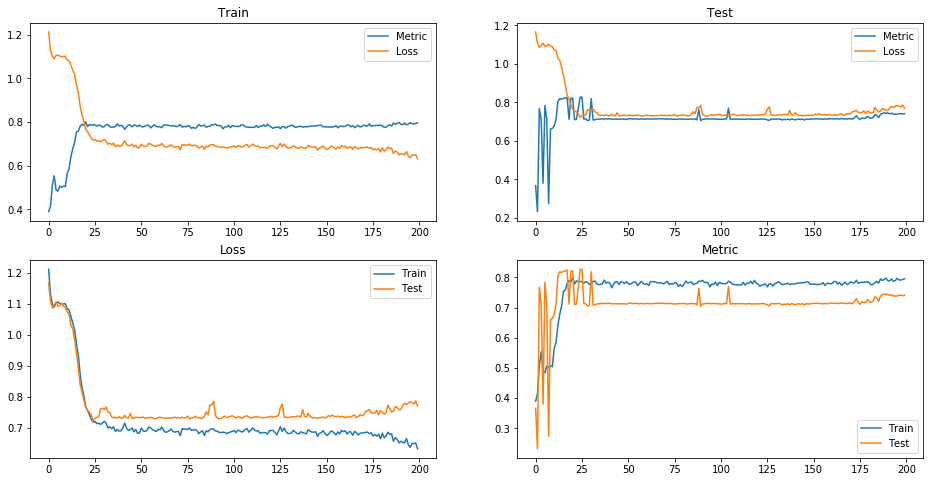

In [66]:
fig = plt.figure()
fig.set_size_inches(16,8)

ax=fig.add_subplot(2,2,1)
ax.plot(hist.history['AUC'])
ax.plot(hist.history['CategoricalCrossentropy'])
ax.legend(['Metric', 'Loss'])
ax.set_title('Train')

ax=fig.add_subplot(2,2,2)
ax.plot(hist.history['val_AUC'])
ax.plot(hist.history['val_CategoricalCrossentropy'])
ax.legend(['Metric', 'Loss'])
ax.set_title('Test')

ax=fig.add_subplot(2,2,3)
ax.plot(hist.history['CategoricalCrossentropy'])
ax.plot(hist.history['val_CategoricalCrossentropy'])
ax.legend(['Train', 'Test'])
ax.set_title('Loss')

ax=fig.add_subplot(2,2,4)
ax.plot(hist.history['AUC'])
ax.plot(hist.history['val_AUC'])
ax.legend(['Train', 'Test'])
ax.set_title('Metric')

plt.show()

In [67]:
results = model.evaluate(X_test, Y_test, verbose=2)

7/7 - 0s - loss: 0.7226 - CategoricalAccuracy: 0.5619 - CategoricalCrossentropy: 0.7326 - AUC: 0.7756


(3.5, -0.5)

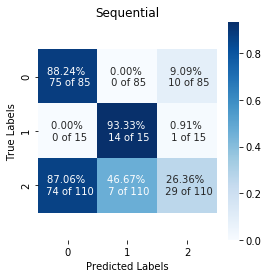

In [68]:
fig = plt.figure()
fig.set_size_inches(4,4)
ax=fig.add_subplot(1,1,1)
title=None
# plot_confusion_matrix(model_st, X, y, ax=fig.add_subplot(1,1,1), normalize=True, title='')

conf_matrix = metrics.confusion_matrix(y_true=[np.argmax(i) for i in Y_test], 
                                       y_pred=[np.argmax(i) for i in model.predict(X_test)],
                                       labels=None)  # returns matrix for sorted classes (i.e 0, 1, 2,..., n)

classes = [0,1,2]
n_classes = [Y_test[Y_test[:,c]==1].shape[0] for c in classes]

normalize = True

if normalize == True:
    n_matrix = [[i for j in range(len(n_classes))] for i in n_classes]
    norm_matrix = conf_matrix / np.array(n_classes)
    ns_matrix = np.array([[i for j in enumerate(n_classes)] for i in n_classes])
    labels = np.array([["{0:.2%} \n {1:d} of {2:d}".format(norm_matrix[i, j], conf_matrix[i, j],
                                                           ns_matrix[i, j]) for j, v in
                        enumerate(norm_matrix[i])]
                       for i, v in enumerate(norm_matrix)])

    sns.heatmap(norm_matrix, annot=labels, fmt='', cmap='Blues')
else:
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

ax.set_ylabel('True Labels')
ax.set_xlabel('Predicted Labels')
if title is None:
    title = model.__class__.__name__
ax.set_title(title)
ttl = ax.title
ttl.set_position([.5, 1.07])

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = ax.get_ylim()  # discover the values for bottom and top
b += 0.5  # Add 0.5 to the bottom
t -= 0.5  # Subtract 0.5 from the top
ax.set_ylim(b, t)  # update the ylim(bottom, top) values

In [14]:
re_create_model(X_train, Y_train, X_val, Y_val, X_test, Y_test, best_run_params)

NameError: name 're_create_model' is not defined

In [25]:
rnd_seed = 30

# model
model = keras.Sequential()

# input
w_init = keras.initializers.he_normal(seed=rnd_seed)
b_init = keras.initializers.Constant(0.001)

in_dropout = 0.1
model.add(keras.layers.Dense(32, 
                             input_dim=len(selected_features),
                             kernel_initializer=w_init,
                             bias_initializer=b_init))
model.add(keras.layers.Activation(keras.layers.LeakyReLU(alpha=0.1)))
model.add(keras.layers.Dropout(rate=in_dropout, seed=rnd_seed))

# hidden layers
h_dropout = 0.1
w_init = keras.initializers.glorot_normal(seed=rnd_seed)
w_init = keras.initializers.he_normal(seed=rnd_seed)
b_init = keras.initializers.Constant(0.0)
model.add(keras.layers.Dense(32,
                             kernel_initializer=w_init,
                             bias_initializer=b_init))
model.add(keras.layers.Activation(keras.layers.LeakyReLU(alpha=0.1)))
model.add(keras.layers.Dropout(rate=h_dropout, seed=rnd_seed))

model.add(keras.layers.Dense(32,
                             kernel_initializer=w_init,
                             bias_initializer=b_init))
model.add(keras.layers.Activation(keras.layers.LeakyReLU(alpha=0.1)))
model.add(keras.layers.Dropout(rate=h_dropout, seed=rnd_seed))

# w_init = keras.initializers.glorot_uniform(seed=rnd_seed)
# b_init = keras.initializers.Constant(0.01)
# model.add(keras.layers.Dense(256,
#                              kernel_initializer=w_init,
#                              bias_initializer=b_init))
# model.add(keras.layers.Activation('tanh'))
# model.add(keras.layers.Dropout(rate=h_dropout, seed=rnd_seed))

# w_init = keras.initializers.glorot_uniform(seed=rnd_seed)
# b_init = keras.initializers.Constant(0.01)
# model.add(keras.layers.Dense(256,
#                              kernel_initializer=w_init,
#                              bias_initializer=b_init))
# model.add(keras.layers.Activation('tanh'))
# model.add(keras.layers.Dropout(rate=h_dropout, seed=rnd_seed))

# model.add(keras.layers.Dense(32,
#                              kernel_initializer=w_init,
#                              bias_initializer=b_init))
# model.add(keras.layers.Activation('tanh'))
# model.add(keras.layers.Dropout(rate=h_dropout, seed=rnd_seed))

# model.add(keras.layers.Dense(128,
#                              kernel_initializer=w_init,
#                              bias_initializer=b_init))
# model.add(keras.layers.Activation('sigmoid'))
# model.add(keras.layers.Dropout(rate=h_dropout, seed=rnd_seed))



# output    
# w_init = keras.initializers.glorot_normal(seed=rnd_seed)
# w_init = keras.initializers.glorot_uniform(seed=rnd_seed)
# b_init = keras.initializers.Constant(0.01)
model.add(keras.layers.Dense(3,
                             kernel_initializer=w_init,
                             bias_initializer=b_init))
model.add(keras.layers.Activation('sigmoid'))

# optimizers
optim = keras.optimizers.Adam(lr=0.00005, beta_1=0.99, beta_2=0.999, amsgrad=True)

METRICS = [keras.metrics.CategoricalAccuracy(name='CategoricalAccuracy'),
           keras.metrics.CategoricalCrossentropy(name='CategoricalCrossentropy'),
           keras.metrics.AUC(name='AUC')]

In [26]:
model.compile(optimizer=optim, 
              loss='categorical_crossentropy', 
              metrics=METRICS)
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 32)                480       
_________________________________________________________________
activation_32 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 32)                1056      
_________________________________________________________________
activation_33 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 32)               

In [44]:
hist = model.fit(X_train, Y_train,
                 class_weight=class_weights,
                 batch_size=32,
                 epochs=200,
                 verbose=1,
                 validation_data=(X_val, Y_val))

Epoch 1/200
21/21 [==============================] - 0s 3ms/step - loss: 1.7037 - CategoricalAccuracy: 0.3308 - CategoricalCrossentropy: 1.2367 - AUC: 0.3982 - val_loss: 1.2776 - val_CategoricalAccuracy: 0.3333 - val_CategoricalCrossentropy: 1.2655 - val_AUC: 0.3661
Epoch 2/200
21/21 [==============================] - 0s 3ms/step - loss: 1.7015 - CategoricalAccuracy: 0.3383 - CategoricalCrossentropy: 1.2193 - AUC: 0.3939 - val_loss: 1.2541 - val_CategoricalAccuracy: 0.3333 - val_CategoricalCrossentropy: 1.2431 - val_AUC: 0.3661
Epoch 3/200
21/21 [==============================] - 0s 3ms/step - loss: 1.6927 - CategoricalAccuracy: 0.3323 - CategoricalCrossentropy: 1.2097 - AUC: 0.3877 - val_loss: 1.2353 - val_CategoricalAccuracy: 0.3333 - val_CategoricalCrossentropy: 1.2254 - val_AUC: 0.3661
Epoch 4/200
21/21 [==============================] - 0s 3ms/step - loss: 1.6866 - CategoricalAccuracy: 0.3219 - CategoricalCrossentropy: 1.1967 - AUC: 0.3772 - val_loss: 1.2196 - val_CategoricalAccur

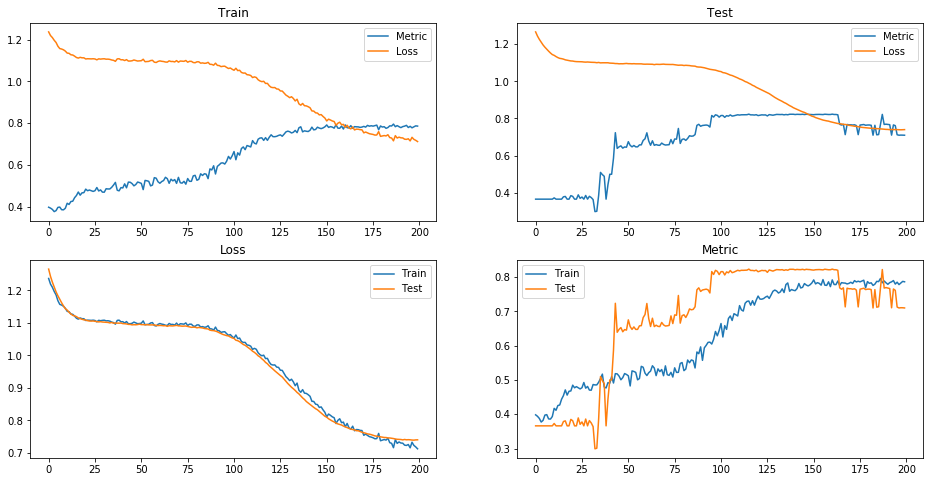

In [45]:
fig = plt.figure()
fig.set_size_inches(16,8)

ax=fig.add_subplot(2,2,1)
ax.plot(hist.history['AUC'])
ax.plot(hist.history['CategoricalCrossentropy'])
ax.legend(['Metric', 'Loss'])
ax.set_title('Train')

ax=fig.add_subplot(2,2,2)
ax.plot(hist.history['val_AUC'])
ax.plot(hist.history['val_CategoricalCrossentropy'])
ax.legend(['Metric', 'Loss'])
ax.set_title('Test')

ax=fig.add_subplot(2,2,3)
ax.plot(hist.history['CategoricalCrossentropy'])
ax.plot(hist.history['val_CategoricalCrossentropy'])
ax.legend(['Train', 'Test'])
ax.set_title('Loss')

ax=fig.add_subplot(2,2,4)
ax.plot(hist.history['AUC'])
ax.plot(hist.history['val_AUC'])
ax.legend(['Train', 'Test'])
ax.set_title('Metric')

plt.show()

In [46]:
results = model.evaluate(X_test, Y_test, verbose=2)

7/7 - 0s - loss: 0.7585 - CategoricalAccuracy: 0.4762 - CategoricalCrossentropy: 0.7629 - AUC: 0.7460


(3.5, -0.5)

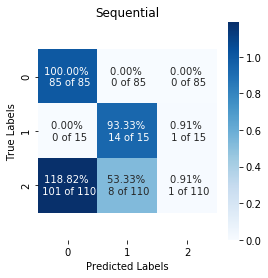

In [47]:
fig = plt.figure()
fig.set_size_inches(4,4)
ax=fig.add_subplot(1,1,1)
title=None
# plot_confusion_matrix(model_st, X, y, ax=fig.add_subplot(1,1,1), normalize=True, title='')

conf_matrix = metrics.confusion_matrix(y_true=[np.argmax(i) for i in Y_test], 
                                       y_pred=[np.argmax(i) for i in model.predict(X_test)],
                                       labels=None)  # returns matrix for sorted classes (i.e 0, 1, 2,..., n)

classes = [0,1,2]
n_classes = [Y_test[Y_test[:,c]==1].shape[0] for c in classes]

normalize = True

if normalize == True:
    n_matrix = [[i for j in range(len(n_classes))] for i in n_classes]
    norm_matrix = conf_matrix / np.array(n_classes)
    ns_matrix = np.array([[i for j in enumerate(n_classes)] for i in n_classes])
    labels = np.array([["{0:.2%} \n {1:d} of {2:d}".format(norm_matrix[i, j], conf_matrix[i, j],
                                                           ns_matrix[i, j]) for j, v in
                        enumerate(norm_matrix[i])]
                       for i, v in enumerate(norm_matrix)])

    sns.heatmap(norm_matrix, annot=labels, fmt='', cmap='Blues')
else:
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

ax.set_ylabel('True Labels')
ax.set_xlabel('Predicted Labels')
if title is None:
    title = model.__class__.__name__
ax.set_title(title)
ttl = ax.title
ttl.set_position([.5, 1.07])

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = ax.get_ylim()  # discover the values for bottom and top
b += 0.5  # Add 0.5 to the bottom
t -= 0.5  # Subtract 0.5 from the top
ax.set_ylim(b, t)  # update the ylim(bottom, top) values

In [835]:
class_weights = {}
for i in range(Y_train.shape[1]):
        class_weights[i] = Y_train.shape[0] / Y_train[Y_train[:,i]==1].shape[0]

In [931]:
class_weights

{0: 5.344, 1: 23.43859649122807, 2: 3.700831024930748}

In [725]:
class_weights = {0:2.76,
                 1:10.77,
                 2:2.76}

In [157]:
class_weights[2]=class_weights[2]+0.3

In [23]:
age_cls_model = pickle.load(open('age_cls_model_02.mdl', 'rb'))

In [24]:
X = test[selected_features]
y = test[target]

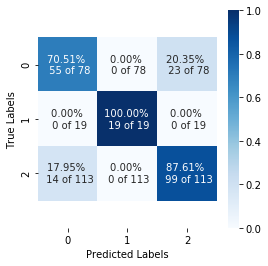

In [25]:
fig = plt.figure()
fig.set_size_inches(4,4)
plot_confusion_matrix(age_cls_model, X, y, ax=fig.add_subplot(1,1,1), normalize=True, title='')

In [402]:
scoring = {'roc_auc_ovr':  metrics.make_scorer(roc_auc_score_ovr, needs_proba=True),
           'roc_auc_ovo':  metrics.make_scorer(roc_auc_score_ovo, needs_proba=True)}
cv = model_selection.StratifiedShuffleSplit(n_splits=10, test_size=0.3, train_size=0.6, random_state=30)
cv_rep(age_cls_model, X, y, cv, scoring)

,roc_auc_ovr,roc_auc_ovo
mean_train,0.954231,0.972080
std_train,0.012967,0.007874
mean_test,0.817452,0.864915
std_test,0.044881,0.040210


#### Define cross validation strategy

In [109]:
random_state=30
cv = model_selection.StratifiedShuffleSplit(n_splits=10, test_size=0.3, train_size=0.6, random_state=random_state)
scoring = {'balanced_accuracy': 'balanced_accuracy',
           'roc_auc_ovr':  metrics.make_scorer(roc_auc_score_ovr, needs_proba=True),
           'roc_auc_ovo':  metrics.make_scorer(roc_auc_score_ovo, needs_proba=True),
           'precision_macro': 'precision_macro'}
refit = 'roc_auc_ovr'

##### Initial model

In [114]:
params = {'learning_rate': 0.1, 
          'n_estimators': 25,
          'min_weight_fraction_leaf': 0.099, 
          'min_impurity_decrease': 0.05,
          'max_depth': 4,
          'subsample': 1.0,
          'ccp_alpha': 0.0}

age_cls_model = ens.GradientBoostingClassifier(loss='deviance', criterion='friedman_mse', 
                                               random_state=random_state, **params)
cv_rep(age_cls_model, X, y, cv, scoring)

,balanced_accuracy,roc_auc_ovr,roc_auc_ovo,precision_macro
mean_train,0.743869,0.862951,0.903441,0.747733
std_train,0.013838,0.006075,0.004483,0.010848
mean_test,0.706854,0.826376,0.877185,0.706078
std_test,0.042856,0.016959,0.014787,0.029135


##### Tune parameters

In [115]:
param_ranges = {'learning_rate': np.linspace(0.001, 2, 40), 'n_estimators': np.arange(5, 100, 20)}
age_cls_model, scores = train_best_model(age_cls_model, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy  roc_auc_ovr  roc_auc_ovo  precision_macro
mean_train           0.784003     0.871729     0.922254         0.802312
std_train            0.008738     0.005815     0.003538         0.009796
mean_test            0.731721     0.827037     0.881948         0.739057
std_test             0.021660     0.015277     0.012377         0.022379
{'learning_rate': 0.8211025641025641, 'n_estimators': 5}


In [116]:
param_ranges = {'min_weight_fraction_leaf': np.linspace(0.001, 0.2, 40), 'min_impurity_decrease': np.linspace(0.0001, 0.1, 40)}
age_cls_model, scores = train_best_model(age_cls_model, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy  roc_auc_ovr  roc_auc_ovo  precision_macro
mean_train           0.772475     0.869702     0.930477         0.790327
std_train            0.012243     0.006141     0.003292         0.019923
mean_test            0.732645     0.827732     0.881093         0.735938
std_test             0.023862     0.014989     0.012767         0.014681
{'min_impurity_decrease': 0.005223076923076923, 'min_weight_fraction_leaf': 0.11325641025641026}


In [117]:
param_ranges = {'subsample': np.linspace(0.1, 1.0, 50), 'max_depth': np.arange(3, 10)}
age_cls_model, scores = train_best_model(age_cls_model, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy  roc_auc_ovr  roc_auc_ovo  precision_macro
mean_train           0.767685     0.869702     0.911581         0.767422
std_train            0.014709     0.006141     0.004395         0.017185
mean_test            0.736763     0.827732     0.880512         0.728696
std_test             0.023178     0.014989     0.015460         0.026185
{'max_depth': 4, 'subsample': 1.0}


In [118]:
param_ranges = {'ccp_alpha': np.linspace(0.00001,0.0001, 99)}
age_cls_model, scores = train_best_model(age_cls_model, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy  roc_auc_ovr  roc_auc_ovo  precision_macro
mean_train           0.765663     0.869649     0.910198         0.766038
std_train            0.016636     0.006250     0.005508         0.010258
mean_test            0.724570     0.827784     0.880279         0.719945
std_test             0.024520     0.015087     0.013548         0.021067
{'ccp_alpha': 1e-05}


### Train regression model for age prediction

In [147]:
X = data.drop(columns=['Age'])
X = pd.get_dummies(X, columns=['Age_cls'])
y = data['Age']

#### Define cross validation strategy

In [148]:
random_state=30
cv = model_selection.RepeatedKFold(n_splits=5, n_repeats=10, random_state=random_state)
scoring = {'explained_variance':  'explained_variance', 'r2': 'r2'}
refit='r2'

##### Initial model

In [149]:
params = {'learning_rate': 0.1, 
          'n_estimators': 55,
          'min_weight_fraction_leaf': 0.001, 
          'min_impurity_decrease': 0.5,
          'max_depth': 3,
          'subsample': 1.0,
          'ccp_alpha': 0.001}

age_reg_model = ens.GradientBoostingRegressor(loss='ls', criterion='friedman_mse', random_state=random_state, **params)
cv_rep(age_reg_model, X, y, cv, scoring)

,explained_variance,r2
mean_train,0.855506,0.855506
std_train,0.006636,0.006636
mean_test,0.798998,0.797667
std_test,0.042477,0.042920


##### Tune parameters

In [150]:
param_ranges = {'learning_rate': np.linspace(0.01, 0.1, 40), 'n_estimators': np.arange(5, 100, 25)}
age_reg_model, scores = train_best_model(age_reg_model, param_ranges, X, y, scoring, cv, refit=refit)

            explained_variance        r2
mean_train            0.854007  0.854007
std_train             0.006734  0.006734
mean_test             0.799742  0.798412
std_test              0.041897  0.042332
{'learning_rate': 0.05846153846153847, 'n_estimators': 55}


In [151]:
param_ranges = {'min_weight_fraction_leaf': np.linspace(0.001, 0.2, 40), 'min_impurity_decrease': np.linspace(0.001, 0.5, 40)}
age_reg_model, scores = train_best_model(age_reg_model, param_ranges, X, y, scoring, cv, refit=refit)

            explained_variance        r2
mean_train            0.854007  0.854007
std_train             0.006734  0.006734
mean_test             0.799742  0.798412
std_test              0.041897  0.042332
{'min_impurity_decrease': 0.4744102564102564, 'min_weight_fraction_leaf': 0.001}


In [152]:
param_ranges = {'max_depth': np.arange(2,10), 'subsample': np.linspace(0.1, 1.0, 50)}
age_reg_model, scores = train_best_model(age_reg_model, param_ranges, X, y, scoring, cv, refit=refit)

            explained_variance        r2
mean_train            0.860054  0.860044
std_train             0.006857  0.006857
mean_test             0.802455  0.801155
std_test              0.041774  0.042037
{'max_depth': 3, 'subsample': 0.41224489795918373}


In [153]:
param_ranges = {'ccp_alpha': np.linspace(0.0001, 0.01, 99)}
age_reg_model, scores = train_best_model(age_reg_model, param_ranges, X, y, scoring, cv, refit=refit)

            explained_variance        r2
mean_train            0.859296  0.859286
std_train             0.006925  0.006925
mean_test             0.802464  0.801170
std_test              0.041363  0.041621
{'ccp_alpha': 0.0016153061224489797}


In [155]:
# Age predict (predict missing vakues and log-transform)
def age_predictor(data, age_cls_model, age_reg_model):
    cols = ['Fare', 'fgrp', 'famsize', 'Ticket', 
            'ttl_1', 'ttl_2','ttl_3', 'ttl_4', 
            'Pclass_0', 'Pclass_1', 'Pclass_2', 
            'Embarked_0', 'Embarked_1', 'Embarked_2']

    data_na = data.loc[data['Age'].isnull()].copy()
    data_notna = data.loc[data['Age'].notna()].copy()

    # predict class labels
    X = data_na[cols].copy()
#     X = pd.get_dummies(X, columns=['ttl', 'Pclass', 'Embarked'])
    X['Age_cls'] = age_cls_model.predict(X)

    # predict age
    X = pd.get_dummies(X, columns=['Age_cls'])
    print(X.columns)
    data_na['Age'] = age_reg_model.predict(X)
    return pd.concat([data_na, data_notna])

Index(['Fare', 'fgrp', 'famsize', 'Ticket', 'ttl_1', 'ttl_2', 'ttl_3', 'ttl_4',
       'Pclass_0', 'Pclass_1', 'Pclass_2', 'Embarked_0', 'Embarked_1',
       'Embarked_2', 'Age_cls_0', 'Age_cls_1', 'Age_cls_2'],
      dtype='object')

## Predict survivals

I will use stacking classifier to predict survivals.

Base classifiers for stacking:
* Linear Discriminant Analysis
* Quadratic Discriminant Analysis
* Extra Trees Classifier
* Random Forest Classifier
* Logistic Regression
* Ridge Classifier
* SVC
* nuSVC

For the final classifier in stacking I chose Ada Boost Classifier.

### Preprocessind data

In [156]:
data = family_groups_encoder(data_train.copy(), fgrp_mask)
data = fare_encoder(data, fare_mask)
data = ticket_encoder(data, ticket_mask)
data = title_encoder(data)
data = sex_encoder(data)
data = fam_size(data)
data = embarked_encoder(data)
data = pclass_encoder(data)

data = data[['PassengerId', 'Survived', 'Age', 'Fare', 'ttl', 'fgrp', 'famsize', 'Ticket', 'Pclass', 'Embarked']]
data = pd.get_dummies(data, columns=['ttl', 'Pclass', 'Embarked'])
data = age_predictor(data, age_cls_model, age_reg_model)

Index(['Fare', 'fgrp', 'famsize', 'Ticket', 'ttl_1', 'ttl_2', 'ttl_3', 'ttl_4',
       'Pclass_0', 'Pclass_1', 'Pclass_2', 'Embarked_0', 'Embarked_1',
       'Embarked_2', 'Age_cls_0', 'Age_cls_1', 'Age_cls_2'],
      dtype='object')


### Plot correlation matrix:

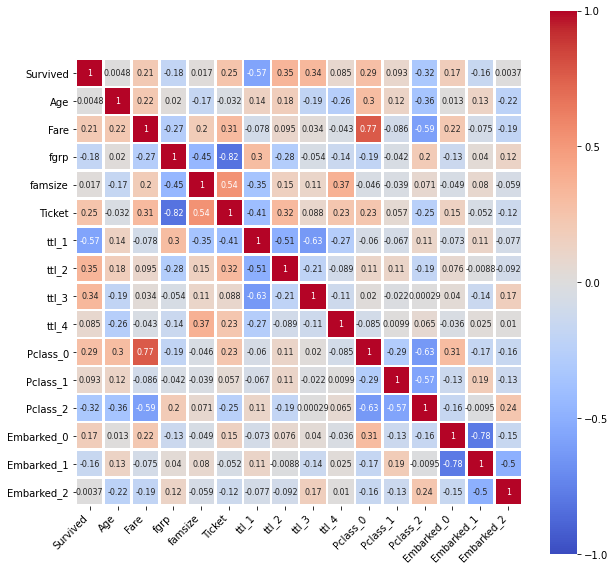

In [157]:
fig = plt.figure()
fig.set_size_inches(10, 10)
corr_matrix = data.drop(columns='PassengerId').corr()
plot_correlation_matrix(ax=fig.add_subplot(1,1,1), data=corr_matrix, cmap='coolwarm')

### Train base estimators for stacking model

In [158]:
X = data.drop(columns=['Survived', 'PassengerId'])
y = data['Survived']

#### Define cross validation strategy

In [159]:
random_state=30
cv = model_selection.StratifiedShuffleSplit(n_splits=10, test_size=0.3, train_size=0.6, random_state=random_state)
scoring = {'balanced_accuracy': 'balanced_accuracy', 
           'roc_auc':  'roc_auc',
           'precision_macro': 'precision_macro'}
refit = 'roc_auc'

#### Calculate class weights and priors

In [160]:
n = len(y)
class_priors = {}
class_weights = {}
for i in y.unique():
    class_priors[i] = len(y.loc[y==i]) / n
    class_weights[i] = 1- class_priors[i]

In [161]:
# Base estomators scores
base_scores = {}

#### LinearDiscriminantAnalysis

In [162]:
# Initialize
lda = disan.LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')

In [205]:
# Tune
param_ranges = {'solver': ['svd', 'lsqr', 'eigen'],}
lda, scores = train_best_model(lda, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.818304  0.872567         0.830353
std_train            0.010123  0.012065         0.008664
mean_test            0.801586  0.860880         0.816270
std_test             0.021881  0.027885         0.021134
{'solver': 'lsqr'}


In [206]:
base_scores['lda'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

#### QuadraticDiscriminantAnalysis

In [165]:
# Initialize
qda = disan.QuadraticDiscriminantAnalysis(priors=[class_priors[0], class_priors[1]], reg_param=0.09)

In [207]:
# Tune
param_ranges = {'reg_param': np.linspace(0.01,0.5,55)}
qda, scores = train_best_model(qda, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.821566  0.887737         0.832871
std_train            0.013759  0.008395         0.009904
mean_test            0.802921  0.869200         0.817799
std_test             0.023669  0.016994         0.028163
{'reg_param': 0.09166666666666666}


/opt/conda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [208]:
base_scores['qda'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

#### ExtraTreesClassifier

In [168]:
# Initialize
etc = ens.ExtraTreesClassifier(random_state=random_state, 
                               n_jobs=-1, 
                               criterion='entropy',
                               n_estimators=75,
                               max_depth=5,
                               ccp_alpha=0.0)

In [169]:
# Tune
param_ranges = {'criterion': ['gini', 'entropy'], 
                'n_estimators': np.arange(60, 100, 5),
                'max_depth': np.arange(3, 10)}
etc, scores = train_best_model(etc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.911797  0.920693         0.850900
std_train            0.009839  0.009068         0.015043
mean_test            0.785322  0.871474         0.831457
std_test             0.018053  0.021378         0.021785
{'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 95}


In [170]:
param_ranges = {'ccp_alpha': np.linspace(0.001,0.01, 60)}
etc, scores = train_best_model(etc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.814684  0.913576         0.867701
std_train            0.010595  0.009508         0.006188
mean_test            0.784872  0.872118         0.831650
std_test             0.025954  0.021655         0.022008
{'ccp_alpha': 0.0020677966101694915}


In [171]:
base_scores['etc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

#### RandomForestClassifier

In [172]:
# Initialize
rfc = ens.RandomForestClassifier(random_state=random_state, n_jobs=-1, criterion='entropy',
                                 n_estimators=20,
                                 max_depth=5,
                                 ccp_alpha=0.04)

In [173]:
param_ranges = {'criterion': ['gini', 'entropy'], 
                'n_estimators': np.arange(5, 100, 10),
                'max_depth': np.arange(3, 10)}
rfc, scores = train_best_model(rfc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.809608  0.869776         0.834213
std_train            0.013400  0.013147         0.019609
mean_test            0.783866  0.862536         0.823277
std_test             0.029032  0.020653         0.036723
{'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 85}


In [174]:
# Tune
param_ranges = {'ccp_alpha': np.linspace(0.001,0.1, 60)}
rfc, scores = train_best_model(rfc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.859342  0.929456         0.849357
std_train            0.015600  0.009061         0.014726
mean_test            0.799688  0.873989         0.848941
std_test             0.024001  0.019816         0.028014
{'ccp_alpha': 0.009389830508474577}


In [175]:
base_scores['rfc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

#### LogisticRegression

In [176]:
# Initialize
lr = lm.LogisticRegression(class_weight=class_weights, 
                           random_state=random_state, 
                           n_jobs=-1,
                           penalty='l2',
                           solver='liblinear',
                           dual=False,
                           C=1.3)

In [177]:
# Tune
param_ranges = {'C': np.linspace(0.01, 5, 99), 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
lr, scores = train_best_model(lr, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.819354  0.874555         0.814789
std_train            0.012784  0.011645         0.012116
mean_test            0.799250  0.866399         0.797918
std_test             0.023801  0.024105         0.022282
{'C': 0.2136734693877551, 'solver': 'liblinear'}


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [178]:
base_scores['lr'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

#### RidgeClassifier

In [179]:
# Initialize
rc = lm.RidgeClassifier(class_weight=class_weights, random_state=random_state,
                        alpha=11.12)

In [180]:
# Tune
param_ranges = {'alpha': np.linspace(1, 45, 99)}
rc, scores = train_best_model(rc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.810671  0.872698         0.812605
std_train            0.011050  0.012155         0.011492
mean_test            0.798023  0.864381         0.802908
std_test             0.021778  0.023432         0.019637
{'alpha': 36.91836734693877}


In [181]:
base_scores['rc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

#### SVC

In [182]:
# Initialize
svc = svm.SVC(kernel='rbf', gamma='scale', shrinking=True, class_weight=class_weights,
              C=2000)

In [183]:
# Tune
param_ranges = {'C': np.linspace(1000, 3000, 55)}
svc, scores = train_best_model(svc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.809380  0.868961         0.819473
std_train            0.012470  0.010208         0.012304
mean_test            0.795107  0.852395         0.803836
std_test             0.025640  0.020558         0.019036
{'C': 2037.037037037037}


In [184]:
base_scores['svc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

In [185]:
# Initialize
nusvc = svm.NuSVC(kernel='rbf', 
                  gamma='scale', 
                  shrinking=True, 
                  class_weight=class_weights,
                  nu=0.51)

In [186]:
# Tune
param_ranges = {'nu': np.linspace(0.1,1.0,99)}
nusvc, scores = train_best_model(nusvc, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.803722  0.857259         0.822608
std_train            0.010337  0.014088         0.010324
mean_test            0.788779  0.836867         0.809869
std_test             0.025946  0.020068         0.023150
{'nu': 0.6602040816326531}


In [187]:
base_scores['nusvc'] = [scores.loc['mean_test', refit], scores.loc['mean_train', refit]]

### Base estimators scores

In [188]:
pd.DataFrame(base_scores, index=['test_score', 'train_score']).sort_values(by='test_score', axis=1,ascending=False)

,rfc,etc,qda,lr,rc,lda,svc,nusvc
test_score,0.873989,0.872118,0.869270,0.866399,0.864381,0.860880,0.852395,0.836867
train_score,0.929456,0.913576,0.887557,0.874555,0.872698,0.872567,0.868961,0.857259


In [190]:
base_models_surv_dic = {'lda':lda,'qda':qda,'etc':etc,'rfc':rfc,'lr':lr,'rc':rc,'svc':svc,'nusvc':nusvc}

In [191]:
base_models_surv = [(k,base_models_surv_dic[k]) for k in base_models_surv_dic.keys()]

### Confusion matrices

/opt/conda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


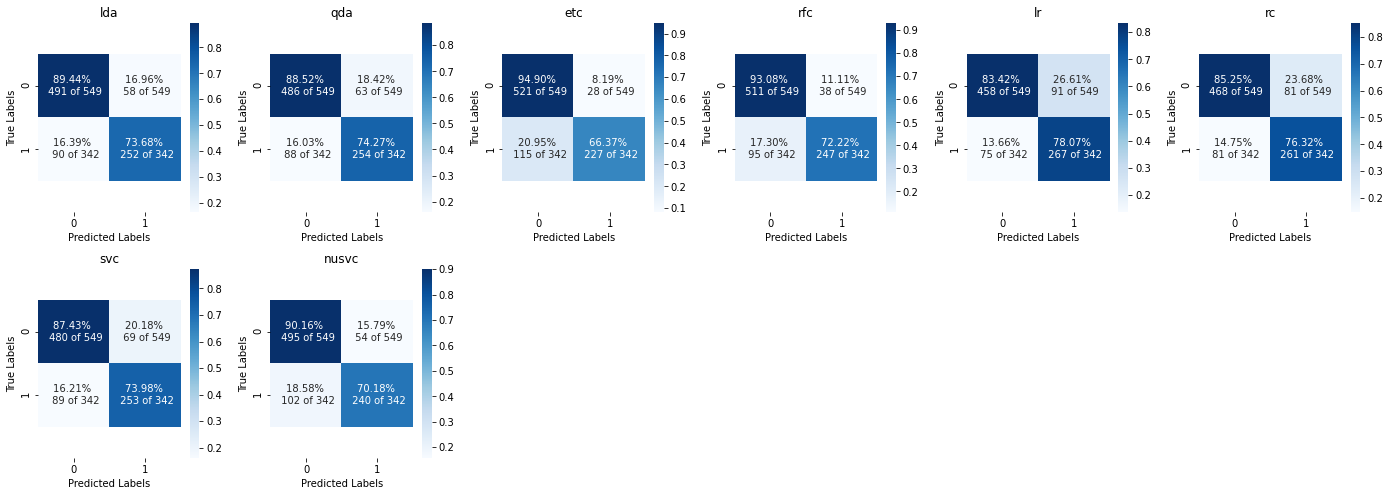

In [192]:
grd_n = len(base_models_surv)
grd_cols_n = 6
grd_rows_n = int(math.ceil(grd_n / grd_cols_n))
fig = plt.figure()
fig.set_size_inches(4 * grd_cols_n, 4 * grd_rows_n)
gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.3)

for i, m in enumerate(base_models_surv):
    lbl, model = m
    plot_confusion_matrix(model, X, y, ax=fig.add_subplot(gs[i]), normalize=True, title=lbl)

### Base estimators correlation matrix

In [193]:
def base_models_predictions(models, X):
    X1 = None
    for i, model in models:
        if X1 is None:
            X1 = pd.Series(model.predict(X), name=i).to_frame()
        else:
            X1 = X1.merge(pd.Series(model.predict(X), name=i).to_frame(), left_index=True, right_index=True)
    return X1

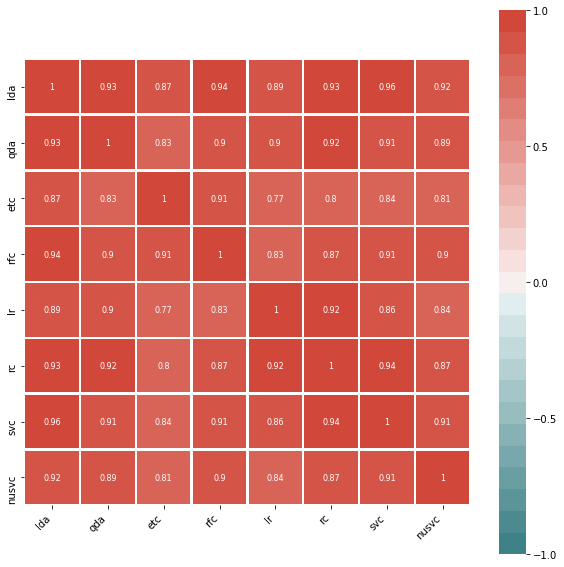

In [194]:
preds_base = base_models_predictions(base_models_surv, X)
fig = plt.figure()
fig.set_size_inches(10, 10)
corr_matrix = preds_base.corr()
plot_correlation_matrix(ax=fig.add_subplot(1,1,1),
                              data=corr_matrix,
                             cmap=sns.diverging_palette(200, 15, s=75, l=50, sep=1, n=25, center='light', as_cmap=False))

In [195]:
# Mean of each model correlation coefficients
corr_sc = {}
for k in base_models_surv_dic.keys():
    corr_sc[k] = (corr_matrix[k].sum() - 1) / len(corr_matrix.index)
df_base_models_corr_sc = pd.DataFrame(corr_sc, index=['cc'])
df_base_models_corr_sc.sort_values(by='cc', axis=1, ascending=False)

,lda,svc,qda,rc,rfc,nusvc,lr,etc
cc,0.803521,0.790198,0.785777,0.78097,0.780824,0.765906,0.751391,0.728686


### Select less correlated models

In [209]:
base_models_surv_dic = {'lda':lda,'etc':etc,'lr':lr,'rc':rc,'svc':svc}

In [210]:
base_models_surv = [(k,base_models_surv_dic[k]) for k in base_models_surv_dic.keys()]

### Train stacking classifier

In [211]:
# Initialize
model_st = ens.StackingClassifier(estimators=base_models_surv,
                                  final_estimator=ens.AdaBoostClassifier(random_state=random_state),
                                  cv=5, 
                                  stack_method='predict', 
                                  passthrough=False,
                                  n_jobs=-1)

cv_rep(model_st, X, y, cv, scoring)

,balanced_accuracy,roc_auc,precision_macro
mean_train,0.820805,0.854874,0.842778
std_train,0.008782,0.012840,0.015375
mean_test,0.795207,0.821906,0.818829
std_test,0.020722,0.029159,0.023984


In [212]:
# Tune
param_ranges = {'final_estimator__n_estimators': np.arange(50, 120, 10), 'final_estimator__learning_rate': np.linspace(0.1, 0.8, 20)}
model_st, scores = train_best_model(model_st, param_ranges, X, y, scoring, cv, refit=refit)

            balanced_accuracy   roc_auc  precision_macro
mean_train           0.821293  0.854050         0.843110
std_train            0.009138  0.013042         0.015400
mean_test            0.795207  0.823719         0.818829
std_test             0.020722  0.028203         0.023984
{'final_estimator__learning_rate': 0.28421052631578947, 'final_estimator__n_estimators': 60}


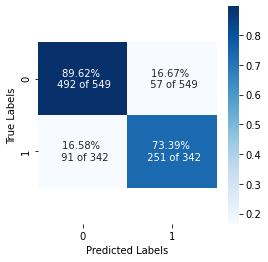

In [213]:
fig = plt.figure()
fig.set_size_inches(4,4)
plot_confusion_matrix(model_st, X, y, ax=fig.add_subplot(1,1,1), normalize=True, title='')

## Predict test set
### Preprocessind data

In [214]:
data = family_groups_encoder(data_test.copy(), fgrp_mask)
data = fare_encoder(data, fare_mask)
data = ticket_encoder(data, ticket_mask)
data = title_encoder(data)
data = sex_encoder(data)
data = fam_size(data)
data = embarked_encoder(data)
data = pclass_encoder(data)

data = data[['PassengerId', 'Age', 'Fare', 'ttl', 'fgrp', 'famsize', 'Ticket', 'Pclass', 'Embarked']]
data = pd.get_dummies(data, columns=['ttl', 'Pclass', 'Embarked'])
data = age_predictor(data, age_cls_model, age_reg_model)

Index(['Fare', 'fgrp', 'famsize', 'Ticket', 'ttl_1', 'ttl_2', 'ttl_3', 'ttl_4',
       'Pclass_0', 'Pclass_1', 'Pclass_2', 'Embarked_0', 'Embarked_1',
       'Embarked_2', 'Age_cls_0', 'Age_cls_1', 'Age_cls_2'],
      dtype='object')


### Make predictions

In [215]:
X = data.drop(columns=['PassengerId'])

In [216]:
data['Survived'] = model_st.predict(X)
df_submission = data[['PassengerId', 'Survived']]
df_submission.to_csv("submission.csv", index=False)